In [80]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [81]:
# Define the model class (same as in your original code)
class StockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,  
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # Single-layer LSTM
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,  
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.output_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_norm(self.input_projection(x))
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.output_norm(x)
        x = self.fc(x)
        
        return x

In [ ]:
# Load your pre-trained model but we'll ignore its scaler
model, _, selected_features, sequence_length = load_model_complete('stock_predictor_complete.pth')
print("Pre-trained model loaded successfully!")
print(f"Selected features: {selected_features}")
print(f"Sequence length: {sequence_length}")

# Load Microsoft dataset
new_data = pd.read_csv('../datasets/MSFT.csv')
print(f"Microsoft data loaded: {new_data.shape}")

# Reset index
new_data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = new_data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
new_data[numeric_data.columns] = new_data[numeric_data.columns].fillna(numeric_data.mean())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Same as in original
for ma in ma_day:
    column_name = f"MA for {ma} days"
    new_data[column_name] = new_data['Close'].rolling(window=ma).mean()

# Calculate Exponential Moving Average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    new_data[column_name] = new_data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
new_data['RSI_14'] = calculate_rsi(new_data['Close'])

# Drop NaN values
new_data.dropna(inplace=True)
print(f"Data after preprocessing: {new_data.shape}")

# Select the same features as used in the original model
msft_features = new_data[selected_features]

# Create a new scaler specifically fitted to Microsoft data
msft_scaler = MinMaxScaler()
scaled_features = msft_scaler.fit_transform(msft_features)

# Create sequences
X_new = []
y_new = []

for i in range(len(scaled_features) - sequence_length):
    X_new.append(scaled_features[i:(i + sequence_length)])
    y_new.append(scaled_features[i + sequence_length, 3])  # Using index 3 for Close price

X_new = torch.FloatTensor(np.array(X_new))
y_new = torch.FloatTensor(np.array(y_new))
print(f"Prepared {len(X_new)} sequences for prediction")

# Create DataLoader for evaluation
batch_size = 128
test_data = torch.utils.data.TensorDataset(X_new, y_new)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Make predictions using the pre-trained model with Microsoft-scaled data
predictions = []
model.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert to numpy array and reshape
predictions = np.array(predictions).reshape(-1, 1)

# Create a full feature array with zeros
predictions_full = np.zeros((predictions.shape[0], len(selected_features)))

# Place predictions in the Close price position (index 3)
predictions_full[:, 3] = predictions.flatten()

# Inverse transform using the Microsoft scaler
predictions = msft_scaler.inverse_transform(predictions_full)[:, 3]

# Get actual Close prices
actual_scaled = np.zeros((len(y_new), len(selected_features)))
actual_scaled[:, 3] = y_new.numpy()
actual_prices = msft_scaler.inverse_transform(actual_scaled)[:, 3]

# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Microsoft Stock Prices (Pre-trained Model with MSFT Scaler)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Split the data to check on train vs test results
test_size = int(0.2 * len(predictions))
train_predictions = predictions[:-test_size]
test_predictions = predictions[-test_size:]
train_actual = actual_prices[:-test_size]
test_actual = actual_prices[-test_size:]

# Plot split results
plt.figure(figsize=(15, 6))
plt.plot(train_actual, label='Train Actual', color='red', alpha=0.7)
plt.plot(train_predictions, label='Train Predictions', color='blue', alpha=0.7)
plt.axvline(x=len(train_actual), color='green', linestyle='--')
plt.plot(range(len(train_actual), len(train_actual) + len(test_actual)), test_actual, label='Test Actual', color='darkred')
plt.plot(range(len(train_predictions), len(train_predictions) + len(test_predictions)), test_predictions, label='Test Predictions', color='darkblue')
plt.title('Train-Test Split: Actual vs Predicted Microsoft Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# Load your new dataset
new_data = pd.read_csv('../datasets/MSFT.csv')
print(f"New data loaded: {new_data.shape}")

# Reset index
new_data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = new_data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
new_data[numeric_data.columns] = new_data[numeric_data.columns].fillna(numeric_data.mean())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Same as in original
for ma in ma_day:
    column_name = f"MA for {ma} days"
    new_data[column_name] = new_data['Close'].rolling(window=ma).mean()

# Calculate Exponential Moving Average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    new_data[column_name] = new_data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
new_data['RSI_14'] = calculate_rsi(new_data['Close'])

# Drop NaN values
new_data.dropna(inplace=True)
print(f"Data after preprocessing: {new_data.shape}")

# Check if all required features are present
missing_features = [feature for feature in selected_features if feature not in new_data.columns]
if missing_features:
    print(f"Warning: Missing features in new dataset: {missing_features}")
else:
    print("All required features are present in the new dataset.")

New data loaded: (2537, 6)
Data after preprocessing: (2488, 15)
All required features are present in the new dataset.


In [75]:
# Select the same features as in the original model
new_features = new_data[selected_features]

# Scale the data using the loaded scaler
scaled_features = scaler.transform(new_features)

# Create sequences (following original notebook's format)
X_new = []
y_new = []

for i in range(len(scaled_features) - sequence_length):
    X_new.append(scaled_features[i:(i + sequence_length)])
    y_new.append(scaled_features[i + sequence_length, 3])  # Using index 3 for Close price

X_new = torch.FloatTensor(np.array(X_new))
y_new = torch.FloatTensor(np.array(y_new))
print(f"Prepared {len(X_new)} sequences for prediction")

# Create DataLoader for evaluation (similar to original)
batch_size = 128
test_data = torch.utils.data.TensorDataset(X_new, y_new)
test_loader = DataLoader(test_data, batch_size=batch_size)


Prepared 2458 sequences for prediction


In [76]:
# Make predictions
predictions = []
model.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert to numpy array and reshape
predictions = np.array(predictions).reshape(-1, 1)

# Create a full feature array with zeros
predictions_full = np.zeros((predictions.shape[0], len(selected_features)))

# Place predictions in the Close price position (index 3)
predictions_full[:, 3] = predictions.flatten()

# Inverse transform to get back to original scale
predictions = scaler.inverse_transform(predictions_full)[:, 3]

# Get actual Close prices - adapted for new data
# Instead of using scaled_data and train_size from original, we use our new scaled data
actual_prices_scaled = np.zeros((len(y_new), len(selected_features)))
actual_prices_scaled[:, 3] = y_new.numpy()
actual_prices = scaler.inverse_transform(actual_prices_scaled)[:, 3]


Performance Metrics:
MSE: 55451.325
RMSE: 235.481
MAE: 229.469
R2 Score: -4.217


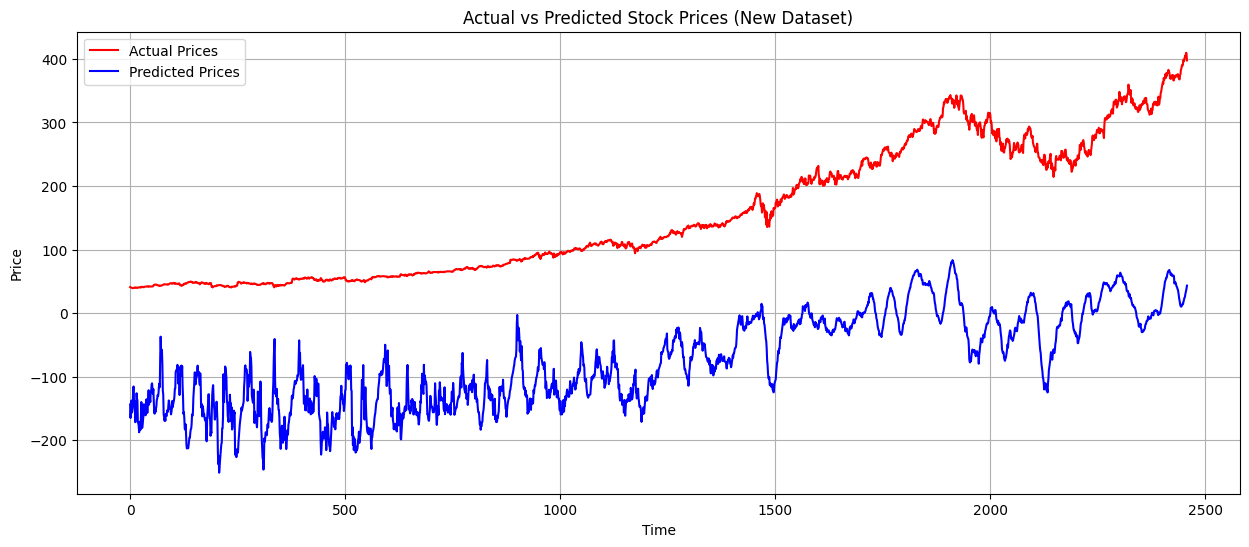

In [77]:
# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices (New Dataset)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\timoz\AppData\Local\Temp\ipykernel_9956\737107610.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Pre-trained model loaded successfully!
Selected features: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA for 5 days', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days', 'EMA for 5 days', 'EMA for 10 days', 'EMA for 20 days', 'EMA for 50 days', 'RSI_14']
Sequence length: 30
Microsoft data loaded: (2537, 6)
Data after preprocessing: (2488, 15)
Prepared 2458 sequences for prediction

Performance Metrics:
MSE: 55957.584
RMSE: 236.554
MAE: 229.659
R2 Score: -4.265


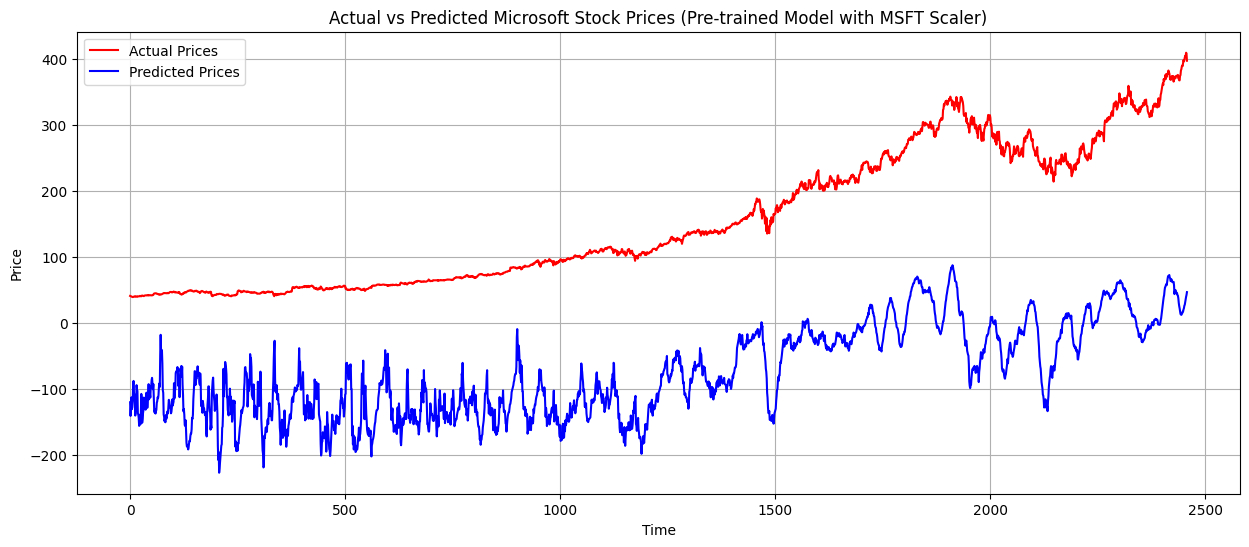

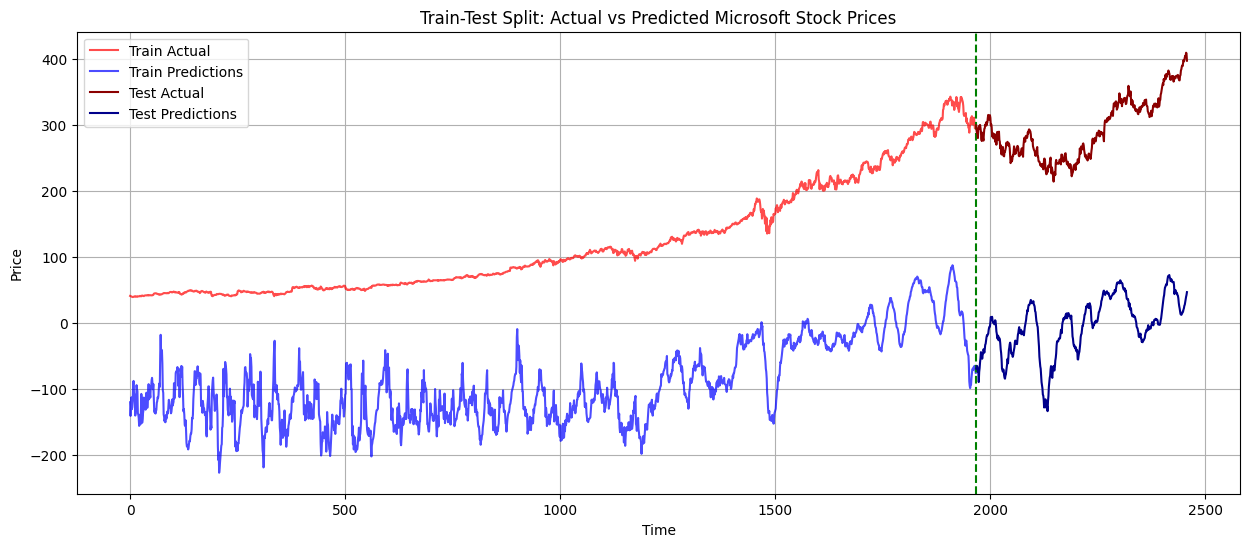

In [82]:
# Load your pre-trained model but we'll ignore its scaler
model, _, selected_features, sequence_length = load_model_complete('stock_predictor_complete.pth')
print("Pre-trained model loaded successfully!")
print(f"Selected features: {selected_features}")
print(f"Sequence length: {sequence_length}")

# Load Microsoft dataset
new_data = pd.read_csv('../datasets/MSFT.csv')
print(f"Microsoft data loaded: {new_data.shape}")

# Reset index
new_data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = new_data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
new_data[numeric_data.columns] = new_data[numeric_data.columns].fillna(numeric_data.mean())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Same as in original
for ma in ma_day:
    column_name = f"MA for {ma} days"
    new_data[column_name] = new_data['Close'].rolling(window=ma).mean()

# Calculate Exponential Moving Average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    new_data[column_name] = new_data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
new_data['RSI_14'] = calculate_rsi(new_data['Close'])

# Drop NaN values
new_data.dropna(inplace=True)
print(f"Data after preprocessing: {new_data.shape}")

# Select the same features as used in the original model
msft_features = new_data[selected_features]

# Create a new scaler specifically fitted to Microsoft data
msft_scaler = MinMaxScaler()
scaled_features = msft_scaler.fit_transform(msft_features)

# Create sequences
X_new = []
y_new = []

for i in range(len(scaled_features) - sequence_length):
    X_new.append(scaled_features[i:(i + sequence_length)])
    y_new.append(scaled_features[i + sequence_length, 3])  # Using index 3 for Close price

X_new = torch.FloatTensor(np.array(X_new))
y_new = torch.FloatTensor(np.array(y_new))
print(f"Prepared {len(X_new)} sequences for prediction")

# Create DataLoader for evaluation
batch_size = 128
test_data = torch.utils.data.TensorDataset(X_new, y_new)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Make predictions using the pre-trained model with Microsoft-scaled data
predictions = []
model.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert to numpy array and reshape
predictions = np.array(predictions).reshape(-1, 1)

# Create a full feature array with zeros
predictions_full = np.zeros((predictions.shape[0], len(selected_features)))

# Place predictions in the Close price position (index 3)
predictions_full[:, 3] = predictions.flatten()

# Inverse transform using the Microsoft scaler
predictions = msft_scaler.inverse_transform(predictions_full)[:, 3]

# Get actual Close prices
actual_scaled = np.zeros((len(y_new), len(selected_features)))
actual_scaled[:, 3] = y_new.numpy()
actual_prices = msft_scaler.inverse_transform(actual_scaled)[:, 3]

# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Microsoft Stock Prices (Pre-trained Model with MSFT Scaler)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Split the data to check on train vs test results
test_size = int(0.2 * len(predictions))
train_predictions = predictions[:-test_size]
test_predictions = predictions[-test_size:]
train_actual = actual_prices[:-test_size]
test_actual = actual_prices[-test_size:]

# Plot split results
plt.figure(figsize=(15, 6))
plt.plot(train_actual, label='Train Actual', color='red', alpha=0.7)
plt.plot(train_predictions, label='Train Predictions', color='blue', alpha=0.7)
plt.axvline(x=len(train_actual), color='green', linestyle='--')
plt.plot(range(len(train_actual), len(train_actual) + len(test_actual)), test_actual, label='Test Actual', color='darkred')
plt.plot(range(len(train_predictions), len(train_predictions) + len(test_predictions)), test_predictions, label='Test Predictions', color='darkblue')
plt.title('Train-Test Split: Actual vs Predicted Microsoft Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()